## <font color="blue">Problem and Key Insight</font>

### Problem & Background

The goal for this project is to try train a model that can forecast Amazon's stock values using Machine Learning given previous stock data.

### Conclusions
LSTM performs better than the Logistic Regression model.
Reasons:
    - prediction values are closer to the actual close values
    - lower RSME

### Next Steps
Next step would be to do more tests on LSTM batch sizes and epoch sizes. Due to lengthy training time for the LSTM  it was hard to test more of these values. Also, how the model performs on current, daily updated values. 

## <font color="blue">Data Exploration and Preparation</font>

### Sources
For this project I combined two datasets. One from Kaggle that includes stock price from 2010 to 2016. Another from the offical NASDAQ website to get stock prices up to 2019. 

Kaggle.com: prices-split-adjusted.csv - open/close/low/high of amazon stock from 2014-2016
Nasdaq.com: historicalquotes.csv - csv from a 3 year timeframe from NASDAQ 2017-present

In [1]:
# Data file location
amzn_stock = '../stock_market_ML_project/amzn_stock_price.csv'

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn import metrics

In [3]:
# create dataframe
amzn_stock_df = pd.read_csv(amzn_stock)
amzn_stock_df.head()

,Unnamed: 0,date,symbol,open,close,low,high,volume
0,284,2010-01-04,AMZN,136.250000,133.899994,133.139999,136.610001,7599900
1,751,2010-01-05,AMZN,133.429993,134.690002,131.809998,135.479996,8851900
2,1219,2010-01-06,AMZN,134.600006,132.250000,131.649994,134.729996,7178800
3,1687,2010-01-07,AMZN,132.009995,130.000000,128.800003,132.320007,11030200
4,2155,2010-01-08,AMZN,130.559998,133.520004,129.029999,133.679993,9830500


In [4]:
# drop insignificant columns and set date as index
amzn_stock_df = amzn_stock_df.drop([amzn_stock_df.columns[0]], axis=1)
amzn_stock_df['date'] = pd.to_datetime(amzn_stock_df['date'],format='%Y-%m-%d')
amzn_stock_df.index = amzn_stock_df['date']
amzn_stock_df = amzn_stock_df.drop(amzn_stock_df[['date','symbol']], axis=1)

/Users/michaelmerani/anaconda/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


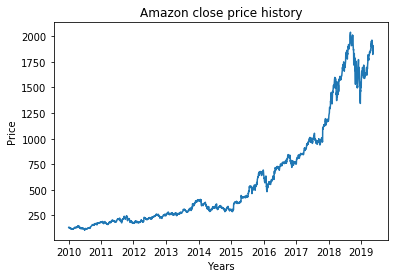

In [5]:
#plotting 'close' from dataset. This is our dependant variable.
plt.plot(amzn_stock_df['close'])
plt.title('Amazon close price history')
plt.xlabel('Years')
plt.ylabel('Price')
plt.show()

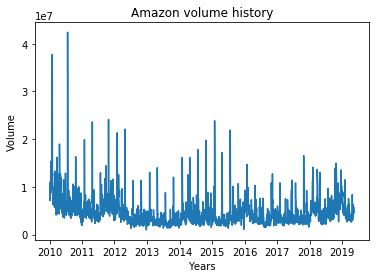

In [6]:
plt.plot(amzn_stock_df['volume'])
plt.title('Amazon volume history')
plt.xlabel('Years')
plt.ylabel('Volume')
plt.show()

### Data Exploration Summary


Above is the graphical representation of the datasets of Amazon stock that I combined. The first chart shows the increase in close price from 2010-2019. We see a steady increase throughout with the most rapid increase happening mid 2017 - mid 2018. The second shows the volume of stocks per day through 2010-2019.

## <font color="blue">Feature Engineering and Selection</font>

Going forward I will be using the open, low, high and volume values to predict close values. I will then normalize (min-max) the values and add them to the dataframe as shown below. 

In [7]:
# method for normalizing dataframe columns (min-max normalization)
from sklearn.preprocessing import MinMaxScaler

def normalize_min_max(column):
    
    x = pd.DataFrame(column)
    minmax_scale = MinMaxScaler().fit(x)
    y = minmax_scale.transform(x)
    
    return y

In [8]:
#normalize data
amzn_stock_df['normalized_open'] = normalize_min_max(amzn_stock_df['open'])
amzn_stock_df['normalized_close'] = normalize_min_max(amzn_stock_df['close'])
amzn_stock_df['normalized_low'] = normalize_min_max(amzn_stock_df['low'])
amzn_stock_df['normalized_high'] = normalize_min_max(amzn_stock_df['high'])
amzn_stock_df['normalized_volume'] = normalize_min_max(amzn_stock_df['volume'])

amzn_stock_df.head()

/Users/michaelmerani/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,open,close,low,high,volume,normalized_open,normalized_close,normalized_low,normalized_high,normalized_volume
date,,,,,,,,,,
2010-01-04,136.250000,133.899994,133.139999,136.610001,7599900,0.015692,0.013098,0.014335,0.013057,0.159653
2010-01-05,133.429993,134.690002,131.809998,135.479996,8851900,0.014233,0.013507,0.013638,0.012474,0.189868
2010-01-06,134.600006,132.250000,131.649994,134.729996,7178800,0.014838,0.012243,0.013554,0.012087,0.149491
2010-01-07,132.009995,130.000000,128.800003,132.320007,11030200,0.013498,0.011078,0.012060,0.010845,0.242437
2010-01-08,130.559998,133.520004,129.029999,133.679993,9830500,0.012747,0.012901,0.012180,0.011546,0.213485


In [9]:
#switch columns so that close is last
cols = list(amzn_stock_df.columns)
a, b = cols.index('normalized_close'), cols.index('normalized_volume')
cols[b], cols[a] = cols[a], cols[b]
amzn_stock_df = amzn_stock_df[cols]

## <font color="blue">Data Models</font>

### Linear Regression Model

The first model I tried was Linear Regression. With this model I am trying to forecast 30 days of stock close prices. First, I make a copy of the dataframe so I can make some changes. Then I add a new column, 'prediction', that will have space for my prediction values. My features will be open, high, low, and volume all normalized. My target will be close values for the last 30 days. 

In [10]:
df_copy = amzn_stock_df.copy()
# create new column for prediction. Predicting last 30 days of stock 'close' prices
df_copy['prediction'] = df_copy[['normalized_close']].shift(-30)
X = df_copy.iloc[:,5:9]

In [11]:
# hold values for forecasting
X_forecast = X[-30:]
# do not include values for the last 30 rows
X = X[:-30]
#set dependant variable
y = np.array(df_copy['prediction'])
y = y[:-30]
# split data for testing and training
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y, test_size = 0.2)

In [12]:
# create model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_lr,y_train_lr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

### LSTM Model

After some research I found that LSTM models have the best results for stock prediction so I decided to use that as my second model. My LSTM consists of LSTM layers with 256 units and .5 dropout. Then 2 Dense layers, one as 'relu' and one 'sigmoid'. Then I build the model with a window of 30 which will look back at prevous 30 days. 

In [ ]:
#pip install keras
#pip install tensorflow

In [13]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras

Using TensorFlow backend.


In [14]:
def test_train_split_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.values 
    sequence_length = seq_len + 1 
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    
    row = round(0.8 * result.shape[0]) # 80% split
    train = result[:int(row), :] # 80% date, all features 
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [15]:
def build_model(layers):
    d = 0.5
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))

    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    
    return model

In [16]:
X = amzn_stock_df.iloc[:,5:10]
window = 30
X_train, y_train, X_test, y_test = test_train_split_data(X, window)

In [17]:
lstm = build_model([5,window,1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
lstm.fit(X_train,y_train,batch_size=512,epochs=90,validation_split=0.1,verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 1675 samples, validate on 187 samples
Epoch 1/90
1675/1675 [==============================] - 9s 6ms/step - loss: 0.0193 - acc: 5.9701e-04 - val_loss: 0.0960 - val_acc: 0.0000e+00
Epoch 2/90
1675/1675 [==============================] - 7s 4ms/step - loss: 0.0075 - acc: 5.9701e-04 - val_loss: 0.0219 - val_acc: 0.0000e+00
Epoch 3/90
1675/1675 [==============================] - 7s 4ms/step - loss: 0.0030 - acc: 5.9701e-04 - val_loss: 0.0262 - val_acc: 0.0000e+00
Epoch 4/90
1675/1675 [==============================] - 7s 4ms/step - loss: 0.0016 - acc: 5.9701e-04 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 5/90
1675/1675 [==============================] - 8s 5ms/step - loss: 9.0535e-04 - acc: 5.9701e-04 - val_loss: 0.0094 - val_acc: 0.0000e+00
Epoch 6/90
1675/1675 [==============================] - 8s 5ms/step - loss: 6.3906e-04 - acc: 5.9701e-04 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 7/90
1675/1675 [=======================

1675/1675 [==============================] - 9s 5ms/step - loss: 1.6685e-04 - acc: 5.9701e-04 - val_loss: 3.2399e-04 - val_acc: 0.0000e+00
Epoch 54/90
1675/1675 [==============================] - 9s 5ms/step - loss: 1.5766e-04 - acc: 5.9701e-04 - val_loss: 3.9978e-04 - val_acc: 0.0000e+00
Epoch 55/90
1675/1675 [==============================] - 9s 5ms/step - loss: 1.7629e-04 - acc: 5.9701e-04 - val_loss: 2.3613e-04 - val_acc: 0.0000e+00
Epoch 56/90
1675/1675 [==============================] - 9s 5ms/step - loss: 1.7402e-04 - acc: 5.9701e-04 - val_loss: 1.4226e-04 - val_acc: 0.0000e+00
Epoch 57/90
1675/1675 [==============================] - 9s 5ms/step - loss: 1.6776e-04 - acc: 5.9701e-04 - val_loss: 4.3506e-04 - val_acc: 0.0000e+00
Epoch 58/90
1675/1675 [==============================] - 9s 5ms/step - loss: 1.6368e-04 - acc: 5.9701e-04 - val_loss: 1.8606e-04 - val_acc: 0.0000e+00
Epoch 59/90
1675/1675 [==============================] - 9s 5ms/step - loss: 1.6611e-04 - acc: 5.9701e-04 

## <font color="blue">Model Evaluations</font>

In [19]:
def denormalize(df, normalized_value): 
    df = df['close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    minmax_scale = MinMaxScaler()
    x = minmax_scale.fit_transform(df)
    denorm = minmax_scale.inverse_transform(normalized_value)
    return denorm

### Linear Regression Evaluation

In [20]:
#make predictions for last 30 days
y_pred_lr = lr.predict(X_forecast)
# denormalize and set prediction in 'predictions' column
new_y_pred = denormalize(df_copy,y_pred_lr)
df_copy.iloc[-30:,-1] = new_y_pred.flatten()

In [21]:
# compare to actual last 30 'normalized_close' values
pd.DataFrame(data={'Close': np.array(amzn_stock_df.iloc[-30:,1]), 'Predictions': new_y_pred.flatten()})

,Close,Predictions
0,1837.28,1905.847272
1,1849.86,1906.898003
2,1835.84,1909.894304
3,1847.33,1907.719138
4,1844.07,1919.120925
5,1843.06,1920.502034
6,1844.87,1893.664867
7,1863.04,1932.853187
8,1864.82,1939.577707
9,1861.69,1938.945183


Text(0, 0.5, 'Price')

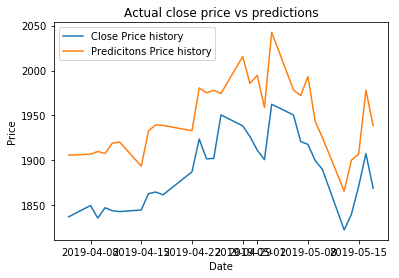

In [22]:
# plot results
plt.figure()
plt.plot(df_copy.iloc[-30:,1], label='Close Price history')
plt.plot(df_copy.iloc[-30:,-1] , label='Predicitons Price history')
plt.legend(loc='best')
plt.title('Actual close price vs predictions')
plt.xlabel('Date')
plt.ylabel('Price')

In [23]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(df_copy.iloc[-30:,1], new_y_pred.flatten())))

Root Mean Squared Error: 63.123620983560464


### LSTM Evaluation

In [24]:
import math
from math import sqrt

def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score:  %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [25]:
y_pred = lstm.predict(X_test)
new_pred = denormalize(amzn_stock_df, y_pred)
newy_test = denormalize(amzn_stock_df, y_test)
model_score(lstm, X_train, y_train, X_test, y_test)

Train Score:  0.00007 MSE (0.01 RMSE)
Test Score: 0.00871 MSE (0.09 RMSE)


(6.831446566574464e-05, 0.008706178300306521)

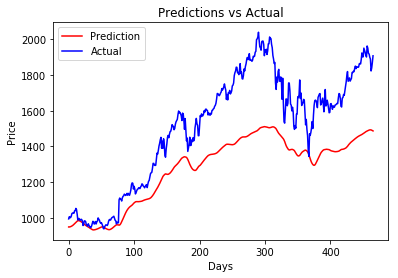

In [35]:
plt.plot(new_pred,color='red', label='Prediction')
plt.plot(newy_test,color='blue', label='Actual')
plt.title('Predictions vs Actual')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()

After evaluating the models we can see that the RSME of the LSTM is better than the Linear Regression model.